# Data preprocessor

In [299]:
import os
import glob
import cv2
import datetime

import pandas as pd

from os import mkdir

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

output_dir = '../data/hnet_training_%s' % datetime.date.today().isoformat()
try: 
    mkdir(output_dir)
except FileExistsError:
    print('directory already exists')

data_dir = r'../data'
original_data_dir = data_dir + ('/learning')
all_files = load_img_paths(original_data_dir)
all_files[:5]

['../data/learning\\Tp26_Y000_X000_040.tif',
 '../data/learning\\Tp26_Y000_X001_040.tif',
 '../data/learning\\Tp26_Y000_X002_040.tif',
 '../data/learning\\Tp26_Y000_X003_040.tif',
 '../data/learning\\Tp26_Y000_X004_040.tif']

In [300]:
import numpy as np
from numpy.random import randint

def aspect_resize(newsize, shape):
    '''
    Given an integer and a shape, return a tuple with the longest side of the shape = newsize
    '''
    m = np.argmax(shape)
    if m == 0:
        return (newsize, int(shape[0] / (shape[1] / newsize)))
    return (int(shape[1] / (shape[0] / newsize)), newsize)

def alter_pt(pt, r):
    r1,r2 = randint(-r,r+1,2)
    return (pt[0] + r1, pt[1] + r2)

def create_patches(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points, r to size-r so as to not go over the edge
        x = randint(r, im.shape[0]-size-r)
        y = randint(r, im.shape[1]-size-r)
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        tl2 = alter_pt(tl, r)
        tr2 = alter_pt(tr, r)
        br2 = alter_pt(br, r)
        bl2 = alter_pt(bl, r)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpPerspective(im, Hab, im.shape, flags=cv2.INTER_CUBIC, \
                                          borderMode=cv2.BORDER_CONSTANT, borderValue=int(im.mean()))
        B = full_warped[y:y+size,x:x+size]
        
        # make sure the images actually have contents.
        thresh = 1600
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])


../data/learning/Tp26_Y000_X001_040.tif (672, 882)
[[ 56.  48.]
 [ 46. -45.]
 [ -5. -17.]
 [-45. -44.]]


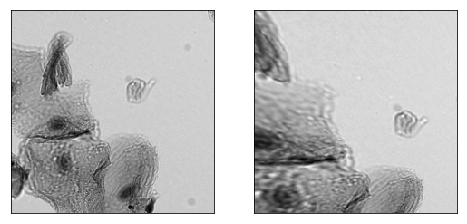

In [301]:
from matplotlib import pyplot as plt

new_size = 672 # 1/2 original, same as paper
patch_size = 224 # 1/3rd image, same as paper
rho = 56 # 1/3rd patch size, as opposed to 1/3rd which led to bad edge effects

fname = '../data/learning/Tp26_Y000_X001_040.tif'
im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
im = cv2.resize(im, aspect_resize(new_size, im.shape), interpolation=cv2.INTER_CUBIC)
print(fname, im.shape)
a,b,h = create_patches(im, patch_size, rho)

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
ref.get_xaxis().set_visible(False)
ref.get_yaxis().set_visible(False)

mov.imshow(b, cmap='gray')
mov.get_xaxis().set_visible(False)
mov.get_yaxis().set_visible(False)

plt.show()

## Generate patches

- `new_size` - recommended that it be small enough so that there is content in the image 320 is what the paper uses. 
- `patch_size` - size of patch, here it's 128, so that horizontally if covers about a third of the image.
- `rho` - we can think of this as overlap, it's the theshold on perturbation in the transform.
- `patches_per_image` - size of inner loop, should probably be greater than 100

> We then generate 500,000 pairs of image patches sized 128x128 related by a homography

This is my "[We're going to need a bigger boat](https://www.youtube.com/watch?v=2I91DJZKRxs)" moment.

In [303]:
df = pd.DataFrame(columns=['fname', 'h'])
new_size = 672 # 1/2 original, same as paper
patch_size = 224 # 1/3rd image, same as paper
rho = 56 # 1/4th patch size, as opposed to 1/3rd which led to bad edge effects

output_size = (112, 112)
ratio = output_size[0] / patch_size

'''
we have 8*15 = 120 images right now...
100 = 1200
500 = 60,000
750 = 90,000
1000 = 120,000
4167 = 500,040
'''

patches_per_image = 500

for f in all_files:
    fname,ext = os.path.basename(f).split('.')
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, aspect_resize(new_size, im.shape))
    for p in range(0, patches_per_image):
        A,B,Hab = create_patches(im, patch_size, rho)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), cv2.resize(A, output_size, interpolation=cv2.INTER_NEAREST))
        cv2.imwrite(os.path.join(output_dir, B_name), cv2.resize(B, output_size, interpolation=cv2.INTER_NEAREST))
        mod_Hab = Hab * ratio
        hab_1d = ','.join(list(map(lambda x: str(float(x)), mod_Hab.reshape(1,8)[0].tolist())))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

In [304]:
df.head()

,fname,h
0,Tp26_Y000_X000_040_0000,"19.5,-22.0,13.5,14.5,-15.5,2.0,-15.0,12.5"
1,Tp26_Y000_X000_040_0001,"-27.5,28.0,2.5,-27.0,-13.5,-21.5,-17.5,10.5"
2,Tp26_Y000_X000_040_0002,"-3.0,-3.0,26.0,-8.5,17.0,-26.0,-11.5,-14.5"
3,Tp26_Y000_X000_040_0003,"10.0,26.0,-21.0,0.5,-12.5,-8.5,0.0,-25.0"
4,Tp26_Y000_X000_040_0004,"9.0,-24.5,-5.5,-0.5,23.0,5.0,-22.5,13.5"


In [305]:
len(df)

60000

## Constant rho

Generate patches where rho is related to overlap. An additional difference is that displacement is constant for each corner. Expected values from a network are in the format (+y,+x).

In [341]:
def alter_pt_constant(pt,x,y):
    return (pt[0] + x, pt[1] + y)

def create_rigid_patches(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points, r to size-r so as to not go over the edge
        x = randint(0, im.shape[1]-size)
        y = randint(0, im.shape[0]-size)
        
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        
        # generate x,y displacements
        x_dis, y_dis = randint(-r, r+1, 2)
        
        # alter points randomly by rho
        tl2 = alter_pt_constant(tl, x_dis, y_dis)
        tr2 = alter_pt_constant(tr, x_dis, y_dis)
        br2 = alter_pt_constant(br, x_dis, y_dis)
        bl2 = alter_pt_constant(bl, x_dis, y_dis)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H)
        # warp image
        
        full_warped = cv2.warpPerspective(im, Hab, im.shape, flags=cv2.INTER_NEAREST, \
                                          borderMode=cv2.BORDER_CONSTANT, borderValue=int(im.mean()))
        B = full_warped[y:y+size,x:x+size]
        
        # make sure the images actually have contents.
        thresh = 2200
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            return A, B, [x_dis, y_dis]

../data/learning/Tp26_Y000_X001_040.tif (672, 882) 336 134.4
[6, 112]


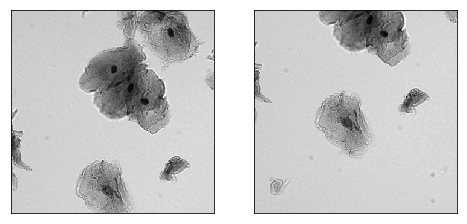

0.98 x, 0.67 y


In [465]:
new_size = 672 # 1/2 original, same as paper
patch_size = new_size // 2 # 1/2 image
rho = patch_size * 4/10 # 2/5th potential distortion = 60% minimum overlap

fname = '../data/learning/Tp26_Y000_X001_040.tif'
im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
im = cv2.resize(im, aspect_resize(new_size, im.shape), interpolation=cv2.INTER_NEAREST)
print(fname, im.shape, patch_size, rho)
a,b,h = create_rigid_patches(im, patch_size, rho)

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
ref.get_xaxis().set_visible(False)
ref.get_yaxis().set_visible(False)

mov.imshow(b, cmap='gray')
mov.get_xaxis().set_visible(False)
mov.get_yaxis().set_visible(False)

plt.show()
print('%.02f x, %0.02f y' % ((patch_size-abs(h[0]))/patch_size, (patch_size-abs(h[1]))/patch_size))

13162 6948


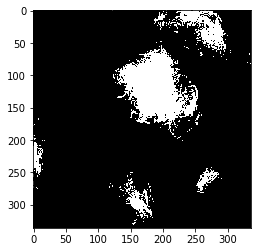

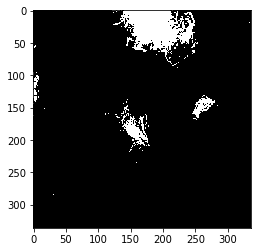

In [466]:
_,a_t = cv2.threshold(a,127,1,cv2.THRESH_BINARY_INV)
_,b_t = cv2.threshold(b,127,1,cv2.THRESH_BINARY_INV)
print(a_t.sum(), b_t.sum())
plt.imshow(a_t, cmap='gray')
plt.show()
plt.imshow(b_t, cmap='gray')
plt.show()

In [467]:
#minimum overlap
(patch_size - rho) / patch_size

0.6

In [468]:
df = pd.DataFrame(columns=['fname', 'h'])
new_size = 672 # 1/2 original, same as paper
patch_size = new_size // 2 # 1/2 image
rho = patch_size * 4/10 # 2/5th potential distortion = 60% minimum overlap

output_size = (128, 128)
ratio = output_size[0] / patch_size

'''
we have 8*15 = 120 images right now...
100 = 1200
500 = 60,000
750 = 90,000
1000 = 120,000
4167 = 500,040
'''

output_dir = '../data/hnet_rigid_training_128%s' % datetime.date.today().isoformat()
try: 
    mkdir(output_dir)
except FileExistsError:
    print('directory already exists')

patches_per_image = 500

for f in all_files:
    fname,ext = os.path.basename(f).split('.')
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, aspect_resize(new_size, im.shape))
    for p in range(0, patches_per_image):
        A,B,Hab = create_rigid_patches(im, patch_size, rho)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), cv2.resize(A, output_size, interpolation=cv2.INTER_NEAREST))
        cv2.imwrite(os.path.join(output_dir, B_name), cv2.resize(B, output_size, interpolation=cv2.INTER_NEAREST))
        mod_Hab = np.array(Hab) * ratio
        hab_1d = ','.join(list(map(lambda x: '%0.03f' % float(x), mod_Hab.reshape(1,2)[0].tolist())))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

In [13]:
df.head()

,fname,h
0,Tp26_Y000_X000_040_0000,"26.667,23.238"
1,Tp26_Y000_X000_040_0001,"36.952,18.286"
2,Tp26_Y000_X000_040_0002,"51.048,41.524"
3,Tp26_Y000_X000_040_0003,"37.333,50.667"
4,Tp26_Y000_X000_040_0004,"22.476,-32.381"
